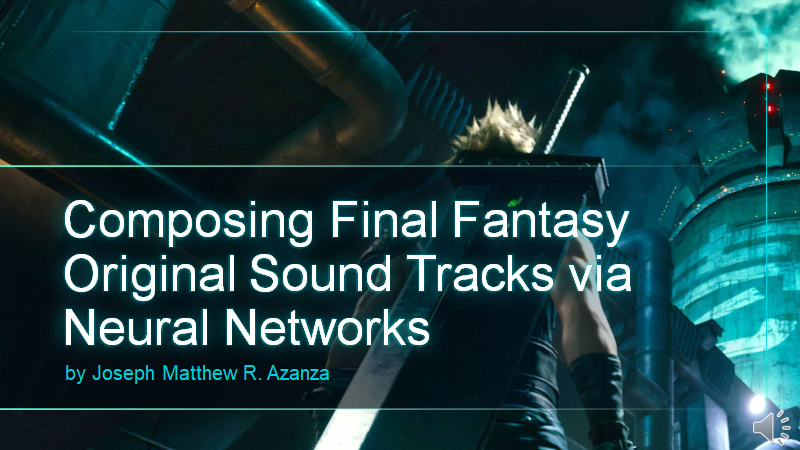

## Executive Summary

This is a passion project driven primarily by my interest in the the music of video games and the Final Fantasy franchise. The goal of this project is to apply my ML2 learnings and use neural networks to compose a Final Fantasy OST. The dataset I used are 100 handpicked MIDI files from Final Fantasy IV, Final Fantasy VII, and Final Fantasy X, representing three different eras of the franchise. The whole intuition of the project revolves around learning the sequences of notes and chords, predicting the next probable note or chord. The best network that I was able to train has 3 LSTMs + 2 sets of Batch Normalization-Dropout-Dense layers, with a validation accuracy of 74.89%. In terms of meeting the project goal, I was able to successfully generate OSTs using the trained network.

My key learnings on this project, both non-technical and technical ones, are summarized below:

|Key Learning||Expanded Description|
|:--:|:--:|:--:|
|Perfect is the enemy of good. ||The AI generated song is not perfect, but I think the network and the output is good enough to stand on its own.|
|The advantage of domain knowledge. ||Having more knowledge of music theory at my disposal can really enhance the output of the network further. At my current state, I am not sure how to include components such as different Note Durations, Rests, and other instruments, in the network training and song generating processes.|
|Importance of having fun and enjoying the process.|| Doing this project felt similar to clearing the final dungeon of a game and I found that enjoying the process made work feel like play. Given the difficult term that we are in, I think it’s important to take a step back and enjoy what we can.|
|The importance of Batch Normalization layer. ||This layer, when applied correctly, can dramatically increase training time while functioning as a regularization layer, hitting two birds with one stone.|
|The importance of understanding the different metrics. ||My experiments lead me to choose between validation accuracy and validation loss, and if I did not have understanding of when is it applicable to choose one over the other, I probably would've beaten myself over and over in attempting to lower the validation loss to be near zero as possible. In reality though, I already have good working model that can generalize with a good accuracy.|
|Leveraging existing works and understanding and adapting them. ||We don't have to start from scratch everytime. Understanding the work of others and leveraging these existing works (with proper citation), is also another important skill that every data scientist must have. Not only does it save time, but it also shows experience and maturity of learnings.|


**Keywords:** music generation, LSTM, Final Fantasy

## 1. Introduction


In a nutshell, this project is a passion project. The main motivation for doing this is to explore how my I can merge my scientific/academic interests with my non-academic ones. For now, let me give a little more background.

Playing video games has been a hobby of mine since I was 5 years-old, and with this "20-year experience," Japanese Role-Playing Games (JRPGs) have been the most impactful in terms of story writing, story execution, gameplay mechanics, and music. From my experience, the music in games is very important for the immersion and experience, to the point that it can make or break the whole experience and the game itself. I have encountered games that have very good storylines and very good mechanics but the music is so bad that I couldn't bring myself to finish the game. I have also played games that have a so-so storyline and just okay mechanics but the music is so good that everytime I pick them up, I was very pumped to continue and see what will happen next.

Established video game critics like IGN, Gamespot, and Screenrant, also agree with my perceived importance of music. In reviewing video games, critics focus on the music with the same effort and scrutiny as to when they review the story, graphics, and game mechanics. Interestingly, published research also support the importance of music in games. Ganiti, et al., (2017) said that "music invokes emotional engagement from players, resulting in better experience," while Zhang and Fu (2015) said that "Music makes gamers be easily absorbed in the gameplay and forget the time passing, leading to more serious time distortion."

### 1.1 Why Final Fantasy

Out of all the games and franchises out there, why am I focusing on the Final Fantasy Franchise? Being my favorite JRPG franchise, I wanted to focus on their music, but aside from playing favorites, Final Fantasy OSTs vary widely, from light-hearted to very emotional ones, giving me wide-range of music to play with. The franchise and the music is also famous to the point that concerts are being held outside of Japan. And in terms of legacy, Nobuo Uematsu, the main composer, is well-regarded to be for changing the course of classical music by inspiring a new generation of classical music lovers and composers. 

### 1.2 Problem Statement

Now, given the very rich background of the Final Fantasy franchise, my goal in this project is very simple. In trying to make my academic and non-academic interests meet, I want to answer this very simple question:

**"How can I apply my ML2 learnings in composing Original Sound Tracks?"**

## 2. Dataset

The dataset used in this study are 100 handpicked MIDI files across three Final Fantasy games that represent certain eras of the franchise. The MIDI files were collected from The Midi Shrine, e.g. collection of MIDI files for [Final Fantasy VII](http://www.midishrine.com/index.php?id=85).

The games and the specific era they represent are as follows:
1. **Final Fantasy IV** for the **Classic Final Fantasy Era**, where Nobuo Uematsu is the sole composer of the tracks and the tracks are rendered in 8-bit
2. **Final Fantasy VII** for the **PlayStation Era** where more advanced tech became available, enabling Nobuo Uematsu to compose more complicated tracks
3. **Final Fantasy X** for the **Collaboration Era** where Nobuo Uematsu first asked other composers to help him in completing the sound track for this game. All other games from this point onwards are now collaborations between different composers, e.g. Masashi Hamauzu, Yoko Shimomura.

The handpicked MIDI files are those that have high variability and examples of these are:
- Character themes
- Boss themes
- Area themes

I've also excluded themes that are largely repetitive and recurring across the different games. These tracks are generally structured the same across the franchise and examples are as follows:
- Opening / Crystal theme
- Battle theme
- Victory Fanfare
- Chocobo theme

## 3. Methodology

The methodology behind this project has been largely inspired by Sigurður Skúli. Uploaded in his [GitHub](https://github.com/Skuldur/Classical-Piano-Composer) is a pipeline which performs exactly what I wanted to do. Since something like this already exists, what I did was to build on top of what he did and try to fit it on my use case.

The methodology of the project is divided into two parts: Network Training and Song Generation. Each step in these parts will be further discussed in the implementation below. Figure 1 shows the pipeline for the Network Training Phase while Figure 2 shows the pipeline for the Song Generation Phase

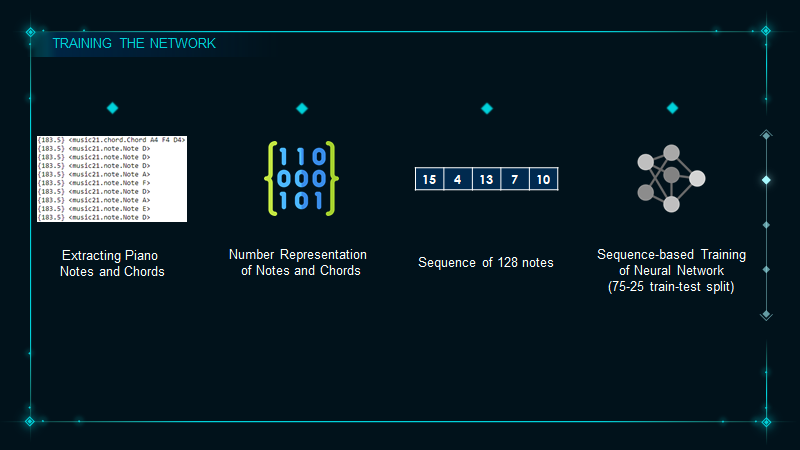

**Figure 1. Network Training Pipeline.**

---

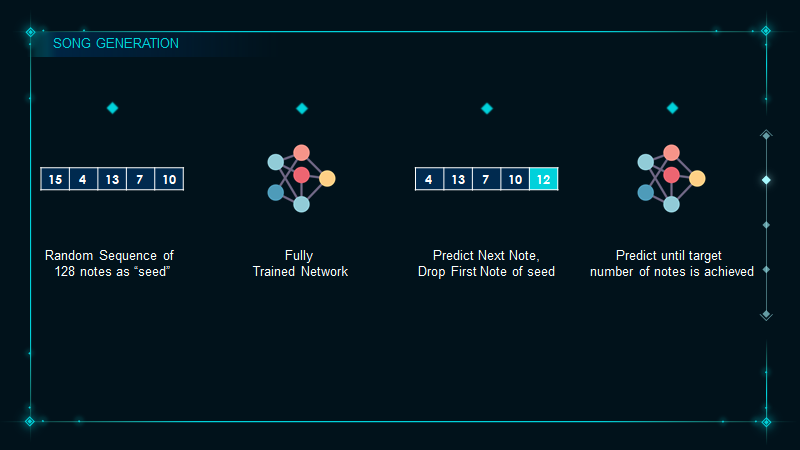

**Figure 2. Song Generation Pipeline.**

### 3.2 Intuition behind the Methodology

For easier understanding, the intuition behind the project revolves around learning sequences of notes and chords. After learning, the network will then predict the next probable note or chord given an initial finite sequence of notes and chords. With this intuition, the architecture that would work best for the problem at hand would be networks that include models capable of handling sequential data, like RNNs, LSTMs, or GRUs.

## 4. Network Training Implementation

This section handles the implementation part of the network training. Due to the absence of a reliable local GPU and the instability of Jojie, the code was ran on Google Colab. As such, the syntax of the code and the filepaths for IO purposes were adjusted to reflect this fact.

### 4.1 Initialization

For faster processing, Google Colab's GPU was enabled. This will allow tensorflow and keras to run using the free GPU of Google Colab

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle

# Music21 imports
from music21 import converter, instrument, note, chord, stream

# Sklearn import
from sklearn.model_selection import train_test_split

# Tensorflow.keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import model_from_json

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 4.2 Sample MIDI file

A MIDI file is technically a set of instructions of how to generate a certain sound. It is neither a music format (MP3, WAV, FLAC), nor does it contain any actual sound. Electronic devices like musical instruments, computer programs etc. reads these instructions and processes them accordingly to convert the stream of notes, chords, and rests to what we perceive as music (howstuffworks, 2020).

In [4]:
drive_path = ("/content/drive/MyDrive/ML2_indiv_project/midi_songs/")

In [5]:
midi = converter.parse((drive_path + "ff7_inclusions/"
                        + "4-16 One Winged Angel Xg.mid"))

midi.flat.notesAndRests.stream().show('text')

{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.0} <music21.note.Rest rest>
{0.5} <music21.note.Rest rest>
{0.5} <music21.note.Rest rest>
{0.5} <music21.note.Rest rest>
{0.5} <music21.note.Rest rest>
{0.5} <music21.note.Rest rest>
{0.5} <music21.note.Rest rest>
{0.5} <music21.note.Rest rest>
{0.5} <music21.note.Rest rest>
{0.5} <music21.note.Rest rest>
{0.5} <music21.note.Rest rest>
{0.5} <music21.note.Rest rest>
{0.5} <music21.note.Rest rest>
{2.0} <music21.note.Note E>
{2.0} <music21.note.Note E>
{2.0} <music21

To provide a more concrete example, I've extracted the stream of rests, notes, and chords from the MIDI file of the `One-Winged Angel` track of `Final Fantasy VII.` The extraction of these musical objects were done using the `music21` library.

### 4.3 Loading the MIDI files

Now that we can extract musical objects from MIDI files using the `music21` library, we start with loading the 100 chosen MIDI files and extracting the corresponding `note`s and `chord`s per MIDI file.

For clarity, a `note` refers to the musical pitch of C, D, E, F, G, A, and B, while a `chord` is a collection of `notes` played at the same time, e.g. `Chord A4, F4, D4, D3`. The  number beside a `note` correponds to the octave that the pitch belongs to, assuming the MIDI file contains it.

In [6]:
# base = "midi_songs/"
# ff4 = base + "ff4_inclusions/*.mid"
# ff7 = base + "ff7_inclusions/*.mid"
# ffx = base + "ffx_inclusions/*.mid"

ff4 = drive_path + "ff4_inclusions/*.mid"
ff7 = drive_path + "ff7_inclusions/*.mid"
ffx = drive_path + "ffx_inclusions/*.mid"

ff_midi = glob.glob(ff4)
ff_midi.extend(glob.glob(ff7))
ff_midi.extend(glob.glob(ffx))

print(f'Total number of MIDI files: {len(ff_midi)} songs')

Total number of MIDI files: 100 songs


100 MIDI files where successfully read and loaded

In [7]:
notes = []

for file in ff_midi:
    midi = converter.parse(file)

    print(f"Parsing {file}")

    notes_to_parse = None

    try: # Checks if midi file has instrument parts
        note2 = instrument.partitionByInstrument(midi)
        notes_to_parse = note2.parts[0].recurse() 
    except: # checks if midi file has notes in a flat structure instead
        notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

print("Parsing successful, now saving notes into a pickle file")

drive_ml2 = "/content/drive/MyDrive/ML2_indiv_project/"
with open(drive_ml2 + 'notes.pkl', 'wb') as filepath:
    pickle.dump(notes, filepath)

Parsing /content/drive/MyDrive/ML2_indiv_project/midi_songs/ff4_inclusions/FF4airsh.mid
Parsing /content/drive/MyDrive/ML2_indiv_project/midi_songs/ff4_inclusions/FF4bab-i.mid
Parsing /content/drive/MyDrive/ML2_indiv_project/midi_songs/ff4_inclusions/FF4baron.mid
Parsing /content/drive/MyDrive/ML2_indiv_project/midi_songs/ff4_inclusions/FF4betra.mid
Parsing /content/drive/MyDrive/ML2_indiv_project/midi_songs/ff4_inclusions/FF4bigwh.mid
Parsing /content/drive/MyDrive/ML2_indiv_project/midi_songs/ff4_inclusions/FF4calbr.mid
Parsing /content/drive/MyDrive/ML2_indiv_project/midi_songs/ff4_inclusions/FF4cave.mid
Parsing /content/drive/MyDrive/ML2_indiv_project/midi_songs/ff4_inclusions/FF4cid.mid
Parsing /content/drive/MyDrive/ML2_indiv_project/midi_songs/ff4_inclusions/FF4dwarf.mid
Parsing /content/drive/MyDrive/ML2_indiv_project/midi_songs/ff4_inclusions/FF4eblan.mid
Parsing /content/drive/MyDrive/ML2_indiv_project/midi_songs/ff4_inclusions/FF4edwar.mid
Parsing /content/drive/MyDrive/ML2_

The code above extracts the piano `note`s and `chord`s for each MIDI file. If the MIDI file has no instrument partitions, only the flat structure, or the plain sequence of notes and chords are extracted. At this stage, I only considered the piano `note`s and `chord`s for simplicity.

In storing the notes, the methods `pitch` and `normalOrder` were used to convert the notes and the chords into a numerical format, but still string data type, following this mapping: <br>
`{'C':'0', 'C#':'1', 'D':'2', 'Eb':'3', 'E':'4', 'F':'5', 'F#':'6', 'G':'7', 'G#':'8', 'A':'9', 'B':'10', 'Bb':'11'}`

The extracted set of notes and chords were also saved into a pickle file as back-up.

In [8]:
n_vocab = len(set(notes))
print(f"Total number of unique notes and chords: {n_vocab}")

Total number of unique notes and chords: 273


In [9]:
list(set(notes))[:10]

['4.6.7.11',
 '2.6.10',
 '3.7',
 '4.8.11',
 '9.11.4',
 '10.0.1',
 '2.4.7.9',
 '4.9',
 '3.7.10',
 '8.1']

A total of `273` unique notes and chords from the 100 MIDI files were saved. A sample representation of the formatted notes and chords is also shown in the parsed list above.

<a id='prep_seq'></a>

### 4.4 Preparing the input sequences

In this section, we will prepare the sequences of notes and chords for the neural network training proper.

In [ ]:
sequence_length = 128

# Get all pitch names
pitch_names = sorted(set([item for item in notes]))

# Create a dictionary to map pitches to integers
note_to_int = dict((note, num) for num, note in enumerate(pitch_names))

network_input = []
network_output = []

# Create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

# Reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

# Normalize input and one-hot encode the output
network_input = network_input / float(n_vocab)

network_output = to_categorical(network_output)

In the code above, I first created a mapping dictionary that maps each unique note and chord to a corresponding integer. This was done so that the neural network can process them correctly. Since `chord` objects are in the format of `integer.integer.integer`, it is better to just create a mapping dictionary with values `0 to 272` that represent the unique notes and chords than to convert the previous saved strings into `int` data type.

After creating a mapping dictionary, a list of sequence inputs and outputs were created. An arbitrary length of `128` sequences was selected. The corresponding output for each input sequence of 128 notes will be the 129th note or chord that comes after the parsed 128 notes. What this means is that the network will train on the 128 notes as input and the correct output for this sequence is the 129th note. This window was slid across the whole sequence of notes and chords to generate a total of `35489` patterns. 

As a form of further processing, the shape of the sequence inputs were also reshaped to a format that was compatible with the LSTM layers. It was also normalized as a form of regularization. 

The sequence outputs were also one-hot encoded for better processing.

### 4.5 Train-test Split

In [ ]:
(x_train, x_val, 
 y_train, y_val) = train_test_split(network_input, network_output,
                                    test_size=0.25, random_state=4710)

Splitting was done 75%-25% with a `random_state==4710` for replicability purposes.

In [ ]:
# Check for splitting shape
print(f"Input shape: {network_input.shape}")
print(f"Output shape: {network_output.shape}")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

Input shape: (35489, 128, 1)
Output shape: (35489, 273)
x_train shape: (26616, 128, 1)
y_train shape: (26616, 273)
x_val shape: (8873, 128, 1)
y_val shape: (8873, 273)


Splitting was successful.

### 4.6 Training Trial 1

Since the inspiration for this project already has a recommended architecture with three LSTM layers at its core, I decided to tweak the core architecture and see what would happen.

#### 4.6.1 Network Architecture

In [ ]:
model = Sequential()
model.add(LSTM(512,
               input_shape=(network_input.shape[1], network_input.shape[2]),
               recurrent_dropout=0.3,
               return_sequences=True))
model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3))
model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3))
model.add(GRU(512))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(n_vocab, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 512)          1052672   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 512)          2099200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 512)          2099200   
_________________________________________________________________
gru (GRU)                    (None, 512)               1575936   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               1

The architecture for this training trial is comprised of 3 LSTM layers plus a GRU layer. The main idea is that the added GRU layer should help with learning the sequences while being lighter in terms of complexity. 

What the batch normalization layer does is to normalize the output per mini-batch of training, i.e. maintains mean output close to 0 and output standard deviation close to 1. This layer was added based on its two theoretical effects of dramatically reducing training time and improving model performance by functioning as a regularization process (Brownlee, 2020). Similarly, the dropout and dense layers were also added as a form of regularization. What we want to avoid here is the overfitting of the network such that regardless of sequence given, only a certain number of notes are being predicted.

#### 4.6.2 Network Training

In [ ]:
# filepath = "weights-improvement-{epoch:02d}-{val_loss:.4f}.hdf5"
filepath = ("/content/drive/MyDrive/ML2_indiv_project/"
            "trial1-best-val_loss-{epoch:02d}-{val_loss:.4f}.hdf5)
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/100
208/208 [==============================] - 257s 1s/step - loss: 5.3589 - acc: 0.0256 - val_loss: 5.3409 - val_acc: 0.0174

Epoch 00001: val_loss improved from inf to 5.34095, saving model to /content/drive/MyDrive/ML2_indiv_project/weights-improvement-01-5.3409.hdf5
Epoch 2/100
208/208 [==============================] - 248s 1s/step - loss: 4.7244 - acc: 0.0358 - val_loss: 5.9304 - val_acc: 0.0183

Epoch 00002: val_loss did not improve from 5.34095
Epoch 3/100
208/208 [==============================] - 249s 1s/step - loss: 4.4757 - acc: 0.0438 - val_loss: 5.0984 - val_acc: 0.0332

Epoch 00003: val_loss improved from 5.34095 to 5.09841, saving model to /content/drive/MyDrive/ML2_indiv_project/weights-improvement-03-5.0984.hdf5
Epoch 4/100
208/208 [==============================] - 249s 1s/step - loss: 4.3777 - acc: 0.0536 - val_loss: 4.6313 - val_acc: 0.0327

Epoch 00004: val_loss improved from 5.09841 to 4.63130, saving model to /content/drive/MyDrive/ML2_indiv_project/weig

Network training was successful and ran for about 7 hours. The network trained took ~250s per step, for 100 epochs with a batch size of 128. Checkpointing model improvement based on the validation loss was also done.

#### 4.6.3 Plotting accuracy and loss values

After training, the stored accuracy and loss values are shown here.

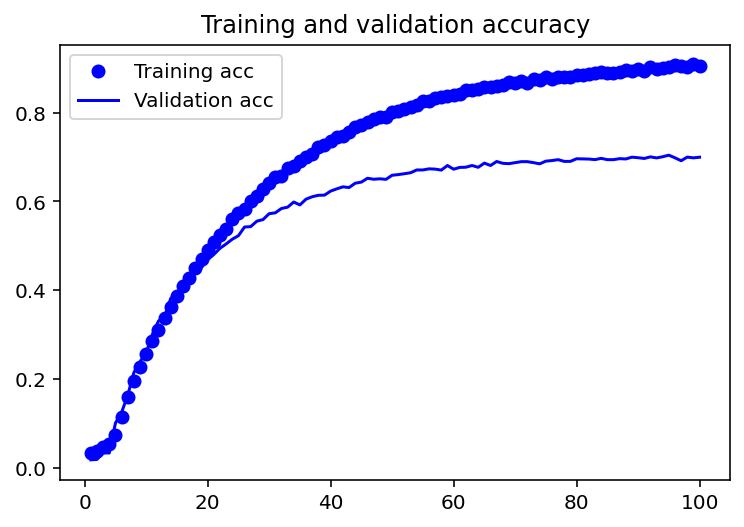

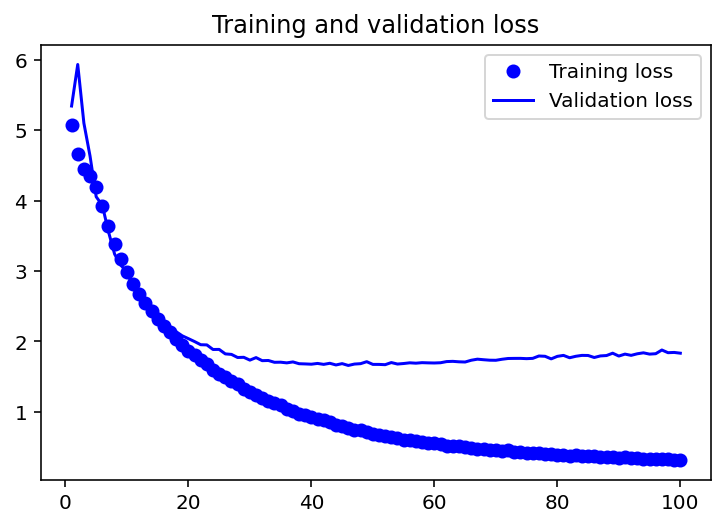

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Figure 3. Trial 1 Accuracy and Loss values.**

For this trial, I wanted to base the success of the training on the `categorical_crossentropy` loss of the validation set. After training the model for about 7 hours, the checkpointed model had a minimized validation loss of 1.65919. The best validation accuracy was also only around 70%.

Ideally, the cross-entropy loss should be as close to zero as possible, but looking at the training and validation loss plot above, it looks like the validation loss will not go down below 1. The training and validation accuracy plots also show that the validation accuracy plateaus at around 70% accuracy.

Since I still have the time to run another model before presenting the results, I decided to check the default architecture recommended by Sigurður Skúli: 3 LSTM layers + 2 layers of Batch Normalization-Dropout-Dense.

### 4.7 Training Trial 2

This trial was intended to apply the default architecture recommended by Sigurður Skúli and just see how this baseline will compare to the tweaking I've done in Trial 1.

#### 4.7.1 Network Architecture

In [ ]:
model2 = Sequential()
model2.add(LSTM(512,
               input_shape=(network_input.shape[1], network_input.shape[2]),
               recurrent_dropout=0.3,
               return_sequences=True))
model2.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3))
model2.add(LSTM(512))
model2.add(BatchNorm())
model2.add(Dropout(0.3))
model2.add(Dense(256, activation='relu'))
model2.add(BatchNorm())
model2.add(Dropout(0.3))
model2.add(Dense(n_vocab, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['acc'])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 512)          1052672   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 512)          2099200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

The architecture for this trial only contains 3 LSTM layers plus the same two sets of Batch Normalization + Dropout + Dense as the network in trial 1. Theoretically, the network in trial 1 (3 LSTMs + GRU) should perform better since it has a deeper network that can account for the sequences in a more complex manner.

#### 4.7.2 Network Training

In [ ]:
# filepath = "weights-improvement-{epoch:02d}-{val_loss:.4f}.hdf5"
file_val_loss = ("/content/drive/MyDrive/ML2_indiv_project/"
                 "trial2-best-val_loss-{epoch:02d}-{val_loss:.4f}.hdf5")

file_val_acc = ("/content/drive/MyDrive/ML2_indiv_project/"
                 "trial2-best-val_acc-{epoch:02d}-{val_acc:.4f}.hdf5")

checkpoint_val_loss = ModelCheckpoint(file_val_loss, 
                                      monitor='val_loss',
                                      verbose=1,
                                      save_best_only=True,
                                      mode='min')

checkpoint_val_acc = ModelCheckpoint(file_val_acc, 
                                     monitor='val_acc',
                                     verbose=1,
                                     save_best_only=True,
                                     mode='max')

callbacks_list = [checkpoint_val_loss, checkpoint_val_acc]
history2 = model2.fit(x_train, y_train, 
                    epochs=125, 
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/125
208/208 [==============================] - 191s 864ms/step - loss: 5.4254 - acc: 0.0269 - val_loss: 7.1966 - val_acc: 0.0066

Epoch 00001: val_loss improved from inf to 7.19661, saving model to /content/drive/MyDrive/ML2_indiv_project/trial2-best-val_loss-01-7.1966.hdf5

Epoch 00001: val_acc improved from -inf to 0.00665, saving model to /content/drive/MyDrive/ML2_indiv_project/trial2-best-val_acc-01-0.0066.hdf5
Epoch 2/125
208/208 [==============================] - 179s 861ms/step - loss: 4.7303 - acc: 0.0360 - val_loss: 7.7445 - val_acc: 0.0099

Epoch 00002: val_loss did not improve from 7.19661

Epoch 00002: val_acc improved from 0.00665 to 0.00992, saving model to /content/drive/MyDrive/ML2_indiv_project/trial2-best-val_acc-02-0.0099.hdf5
Epoch 3/125
208/208 [==============================] - 173s 832ms/step - loss: 4.4883 - acc: 0.0415 - val_loss: 22.8131 - val_acc: 0.0177

Epoch 00003: val_loss did not improve from 7.19661

Epoch 00003: val_acc improved from 0.00992 t

Network training was also successful and ran for about 5.5 hours. The trained network took ~185s per step for 100 epochs with a batch size of 128. Checkpointing model improvement based on the validation loss and validation accuracy was done.

This time, I've included checkpointing for the validation accuracy in the event that the validation loss hovers around 1.5 again.



#### 4.7.3 Plotting accuracy and loss values

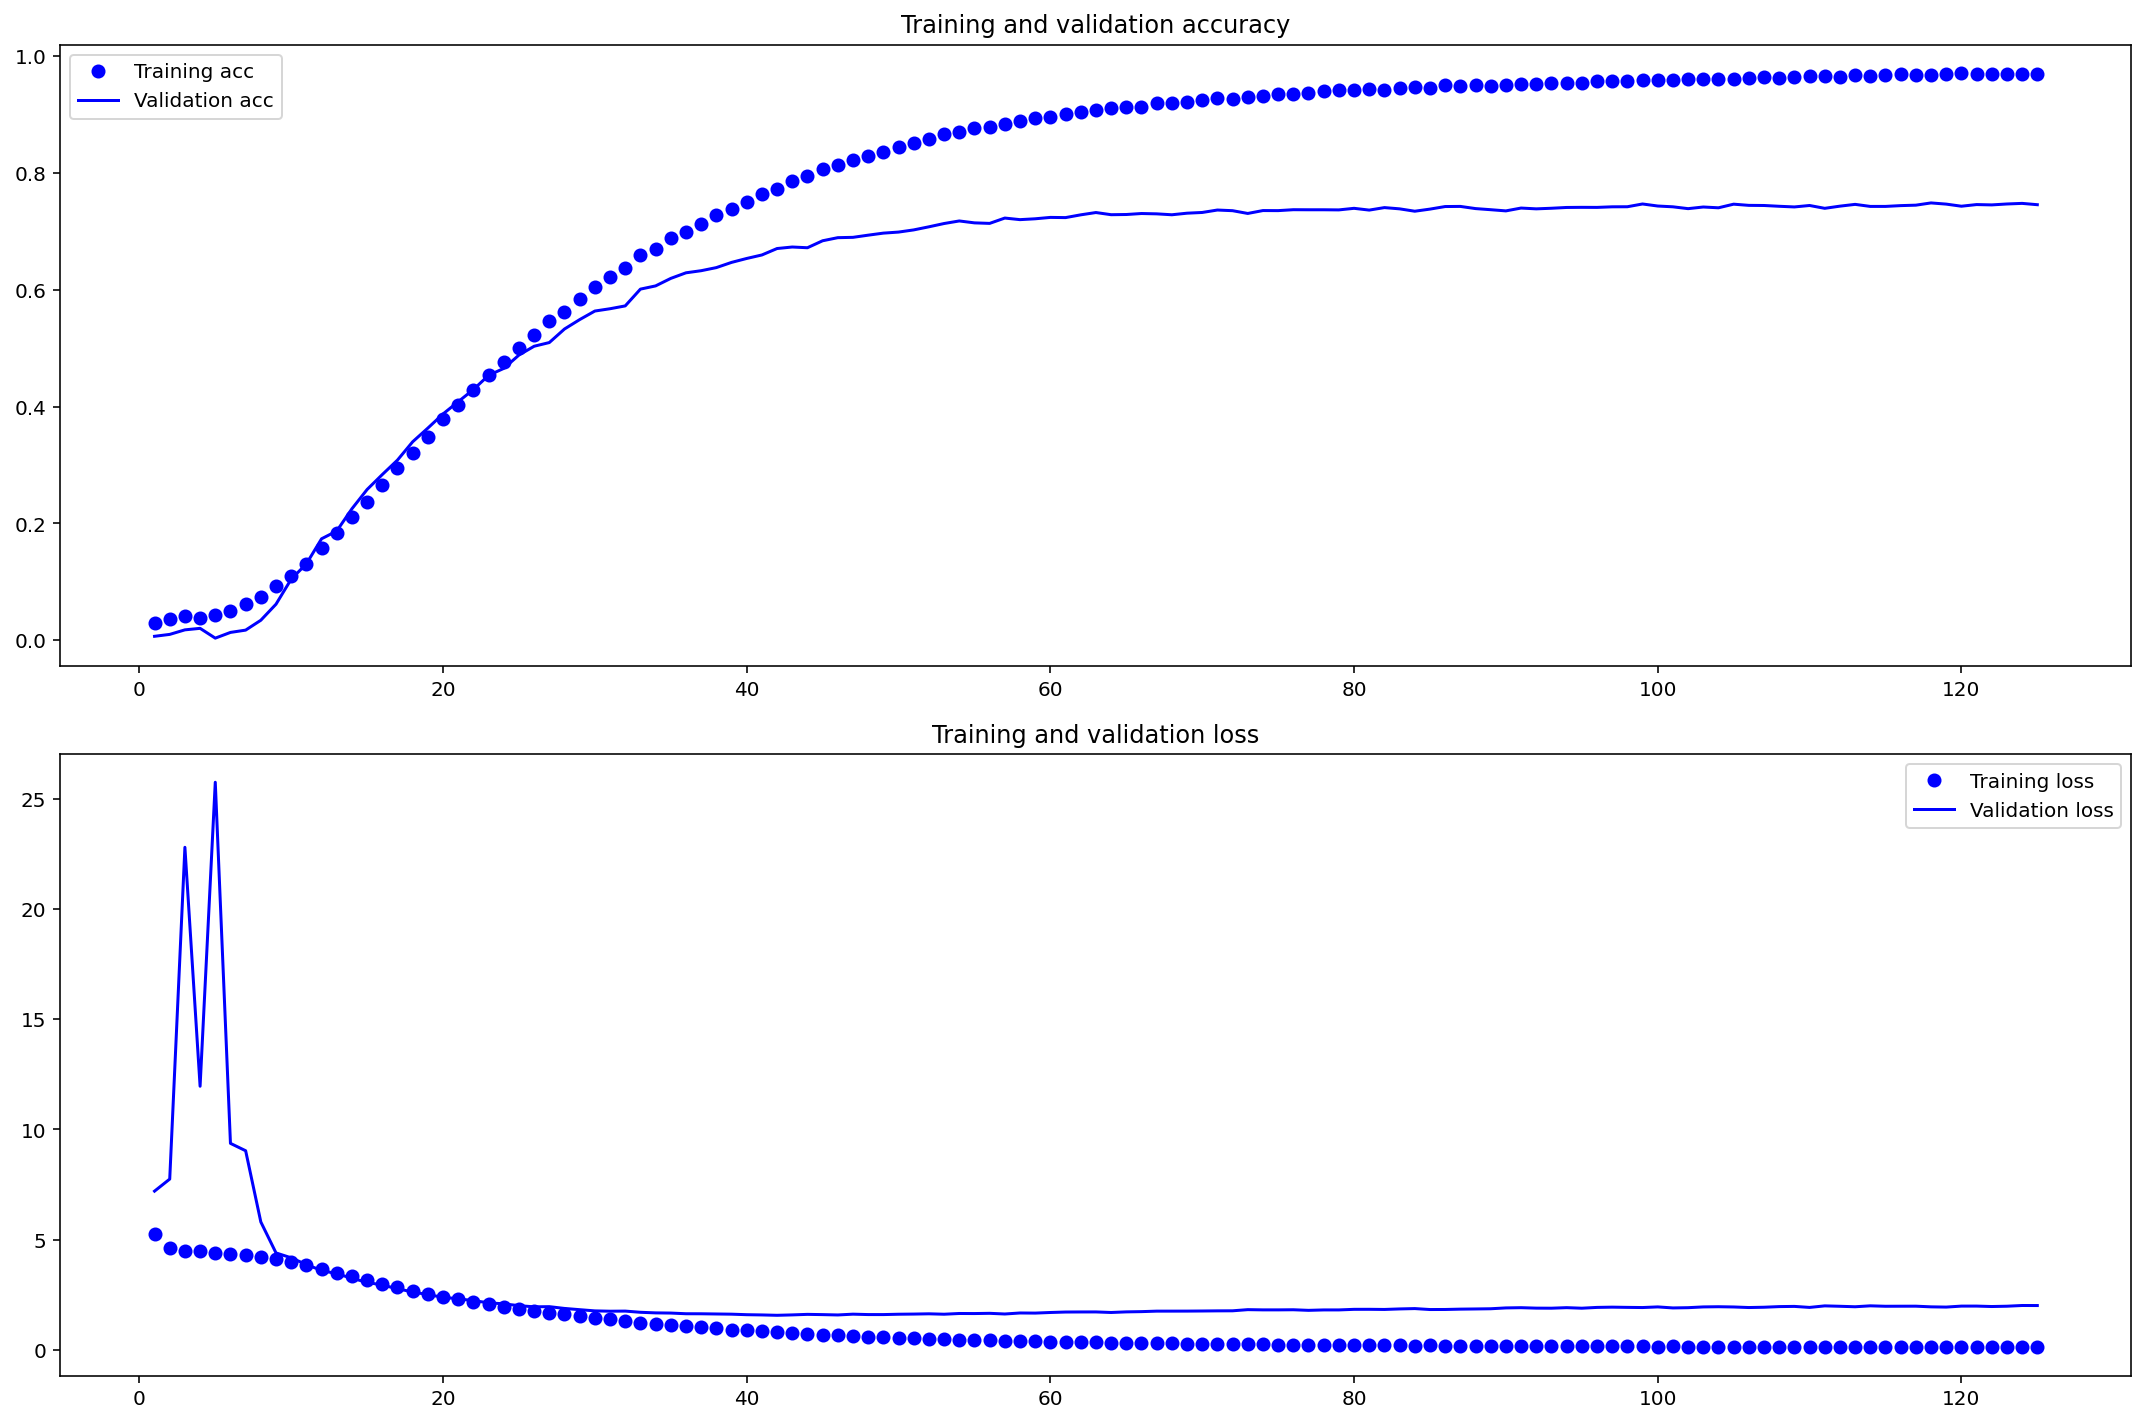

In [ ]:
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs = range(1, len(acc2) + 1)

fig, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].plot(epochs, acc2, 'bo', label='Training acc')
ax[0].plot(epochs, val_acc2, 'b', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss2, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss2, 'b', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.tight_layout()
plt.show()

**Figure 4. Trial 2 Accuracy and Loss values.**

The metrics for the checkpointed models for this trial, plus the metrics for trial 1 are shown in Table 1 below.

**Table 1. Comparison of Trial Metrics** <br>

|Trial|Architecture|Epoch|Validation Accuracy|Validation Loss|
|:--:|:--:|:--:|:--:|:--:|
|1|3 LSTMs + GRU|46|0.6524|1.6592|
|2|3 LSTMs|42|0.6708|1.55726|
|2|3 LSTMs|118|0.7489|1.9412|

Since I wasn't able to checkpoint a model from trial 1 that checks for the maximum validation accuracy, I only have 1 checkpointed model to choose from. However, this is not an issue since I know that the maximum validation accuracy for that architecture is only at around 70%. 

Looking at the accuracy values, the architecture for trial 2 is better, with the validation accuracy reaching as high as 0.7489. In terms of validation loss, the architecture of trial 2 was also able to improve on it but only by a little bit. The lowest validation loss is only at around 1.55726. In choosing which metric to prioritize, I decided that the ability to generalize, i.e. validation accuracy, should be picked. The loss values given here are averages of loss value per prediction and since they are averages, they are highly affected by outliers. The high loss values suggest that there may be some outliers that were predicted wrongly, hence blowing up the metric, but on a larger point of view, the model is still learning from the rest of the training set and can generalize with a certain confidence.

Comparing the 74.89% accuracy to classifcation by chance, which is `1/35489 or 0.002817%` (from the 35,489 patterns earlier), we can see that the 74.89% accuracy of the trained network is miles ahead already.

## 5. Song Generation Implementation (based on Trained Network)

For the second phase, we now generate songs using the trained network. The pipeline for this section is highly similar as to how I processed the notes and trained the network, but this time, instead of training the network, we use the trained network to predict notes.

### 5.1 Initialization

This contains the same initialization as the training section above but I also copied it so that I can just run this section in generating the songs.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [13]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle

# Music21 imports
from music21 import converter, instrument, note, chord, stream, midi

# Sklearn import
from sklearn.model_selection import train_test_split

# Tensorflow.keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import model_from_json

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 5.2 Loading the Notes File and Getting all unique notes

To make my life easier, I will leverage the set of unique notes and chords that I've extracted from the 100 MIDI files and seed random sequences of 128 notes from this set.

In [4]:
drive_ml2 = "/content/drive/MyDrive/ML2_indiv_project/"

with open(drive_ml2 + 'notes.pkl', 'rb') as filepath:
    notes = pickle.load(filepath)

In [5]:
# Check whether it matches
# Results should print 273
n_vocab = len(set(notes))
print(f"Total number of unique notes and chords: {n_vocab}")

Total number of unique notes and chords: 273


### 5.3 Re-prepare sequences

In this section, I just re-prepared the sequence of notes and chords into their numerical representations, as well as create a list of sequence inputs that the neural network can process. The same steps as the one in section [4.4 Preparing the Input sequences](#prep_seq) was done here.

In [7]:
sequence_length = 128

# Get all pitch names
pitch_names = sorted(set([item for item in notes]))

# Create a dictionary to map pitches to integers
note_to_int = dict((note, num) for num, note in enumerate(pitch_names))

network_input = []

for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])

n_patterns = len(network_input)

# reshape the input into a format compatible with LSTM layers
normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

# normalize input
normalized_input = normalized_input / float(n_vocab)

### 5.4 Recreate Network Architecture of choice and Load the trained weights

In [8]:
model_fin = Sequential()
model_fin.add(LSTM(512,
                   input_shape=(normalized_input.shape[1], 
                                normalized_input.shape[2]),
                   recurrent_dropout=0.3,
                   return_sequences=True))
model_fin.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3))
model_fin.add(LSTM(512))
model_fin.add(BatchNorm())
model_fin.add(Dropout(0.3))
model_fin.add(Dense(256, activation='relu'))
model_fin.add(BatchNorm())
model_fin.add(Dropout(0.3))
model_fin.add(Dense(n_vocab, activation='softmax'))
model_fin.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['acc'])

model_fin.load_weights(drive_ml2 + "trial2-best-val_acc-118-0.7489.hdf5")

In [9]:
model_fin.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 512)          1052672   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 512)          2099200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

The architecture of choice, i.e. 3 LSTM layers, was recreated here, and the weights that gave the validation accuracy of 74.89% was loaded into the created model architecture.

### 5.5 Song Generation

After all the preparation above, this section is where we generate the songs given a seed sequence of 128 notes.

In [10]:
# pick a random sequence from the input as a starting point for the prediction
start = np.random.randint(0, len(network_input)-1)

int_to_note = dict((number, note) for number, note in enumerate(pitch_names))

pattern = network_input[start]
prediction_output = []

# generate 500 notes
for note_index in range(500):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)

    prediction = model_fin.predict(prediction_input, verbose=0)

    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)

    pattern.append(index)
    pattern = pattern[1:len(pattern)]

In creating the seed sequence of 128 notes, what I did was to get a random integer from 0 to 35488, and then use this to index the 128-note sequence at that position. I did this so that whatever sequence I get, it is something that is musically objective already, i.e. it's a true sequence of notes and not just a random 128-notes. 

Generating a true random 128-note seed will also work and the network will still predict the next possible note given that seed sequence but I opted to just use the musically objective seed so that what we generate has musical sense.

In the generation portion, we generate a total of 500 notes, or a track with around 1.5 minutes in length. We can generate longer tracks by increasing the note count. Also, the seed sequence is dropped so that we only end up with the 500 notes as our generated track. The sole purpose of the seed sequence is really just to start the song generation as the network cannot predict without an initial sequence.

### 5.6 Create a MIDI file from the generated stream of notes

In [12]:
offset = 0
output_notes = []

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    if ('.' in pattern) or pattern.isdigit(): # pattern is a chord
        notes_in_chord = pattern.split('.')
        notes = []

    for current_note in notes_in_chord:
        new_note = note.Note(int(current_note))
        new_note.storedInstrument = instrument.Piano()
        notes.append(new_note)
    new_chord = chord.Chord(notes)
    new_chord.offset = offset
    output_notes.append(new_chord)
      
      # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

midi_stream = stream.Stream(output_notes)

midi_stream.write('midi', fp=drive_ml2 + 'test_output.mid')

'/content/drive/MyDrive/ML2_indiv_project/test_output.mid'

From the generated stream of notes, I then use `music21` again to convert the sequence of notes into a `MIDI` file that we can listen to. In converting the sequence of notes back to actual `note` objects again, an offset of 0.5 is added so that they don't overlap.

## 6. Comparison of AI Generated Song vs Composed FF OST

To listen to one of the generated samples, just run the code below. All of the other cells above can be ignored. Do note that to listen to the composed song, any playing song should be manually stopped first. The MIDI files may also take a while to load, please be patient.

In case you can't wait or it really does not work (which can happen from time to time, computer to computer, the library is still buggy and kinda hard to debug), I've included the generated songs and the included Final Fantasy MIDI files anyway, in the `generated_songs` and `midi_songs` respectively.

One good website I've tried that can play MIDI files is: http://midiplayer.ehubsoft.net/. Just upload the raw MIDI files to the website and hit play. Powerpoint can also play MIDI files by inserting the file and just playing it.

### 6.1 Generated song

In [6]:
from music21 import midi

path = "./generated_songs/song_output_1.mid"
mf = midi.MidiFile()
mf.open(path) 
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')

### 6.2 Composed OST

In [3]:
from music21 import midi

path2 = "./midi_songs/ffx_inclusions/1-02 - To Zanarkand.mid"
mf2 = midi.MidiFile()
mf2.open(path2) 
mf2.read()
mf2.close()
s2 = midi.translate.midiFileToStream(mf2)
s2.show('midi')

## 7. Run this section to generate N number of songs without re-running the whole notebook

Note: Please change the filepaths if going to run locally

In [4]:
# Input here how many songs to create
# Default is 5

song_count = 5

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle

# Music21 imports
from music21 import converter, instrument, note, chord, stream, midi

# Sklearn import
from sklearn.model_selection import train_test_split

# Tensorflow.keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import model_from_json

from google.colab import drive
drive.mount('/content/drive')

drive_ml2 = "/content/drive/MyDrive/ML2_indiv_project/"

with open(drive_ml2 + 'notes.pkl', 'rb') as filepath:
    notes = pickle.load(filepath)

n_vocab = len(set(notes))

sequence_length = 128

# Get all pitch names
pitch_names = sorted(set([item for item in notes]))

# Create a dictionary to map pitches to integers
note_to_int = dict((note, num) for num, note in enumerate(pitch_names))

network_input = []

for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])

n_patterns = len(network_input)

# reshape the input into a format compatible with LSTM layers
normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

# normalize input
normalized_input = normalized_input / float(n_vocab)

model_fin = Sequential()
model_fin.add(LSTM(512,
                   input_shape=(normalized_input.shape[1], 
                                normalized_input.shape[2]),
                   recurrent_dropout=0.3,
                   return_sequences=True))
model_fin.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3))
model_fin.add(LSTM(512))
model_fin.add(BatchNorm())
model_fin.add(Dropout(0.3))
model_fin.add(Dense(256, activation='relu'))
model_fin.add(BatchNorm())
model_fin.add(Dropout(0.3))
model_fin.add(Dense(n_vocab, activation='softmax'))
model_fin.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['acc'])

model_fin.load_weights(drive_ml2 + "trial2-best-val_acc-118-0.7489.hdf5")

for song in range(5):
    # pick a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(network_input)-1)
    
    int_to_note = dict((number, note) for number, 
                       note in enumerate(pitch_names))
    
    pattern = network_input[start]
    prediction_output = []
    
    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)
    
        prediction = model_fin.predict(prediction_input, verbose=0)
    
        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)
    
        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    offset = 0
    output_notes = []
    
    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        if ('.' in pattern) or pattern.isdigit(): # pattern is a chord
            notes_in_chord = pattern.split('.')
            notes = []
    
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
          
          # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
    
        # increase offset each iteration so that notes do not stack
        offset += 0.5
    
    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=drive_ml2 + f'song_output_{song}.mid')

SyntaxError: invalid syntax (<ipython-input-5-518d80ab098c>, line 127)

## 8. Conclusion
In conclusion, I was able to successfully apply my learnings in ML2 and compose OSTs using neural networks. I was successful in making my academic and non-academic interests meet.

For my learnings, these are the ones I presented in class:

1. Perfect is the enemy of good. The AI generated song is not perfect, but I think the network and the output is good enough to stand on its own.
2. The advantage of domain knowledge. Having more knowledge of music theory at my disposal can really enhance the output of the network further. At my current state, I am not sure how to include components such as different Note Durations, Rests, and other instruments, in the network training and song generating processes.
3. Importance of having fun and enjoying the process.  Doing this project felt similar to clearing the final dungeon of a game and I found that enjoying the process made work feel like play. Given the difficult term that we are in, I think it’s important to take a step back and enjoy what we can.

Most of the points above are non-technical and more geared towards storytelling purposes, I have technical learnings as well: 

1. The importance of Batch Normalization layer. This layer, when applied correctly, can dramatically increase training time while functioning as a regularization layer, hitting two birds with one stone.
2. The importance of understanding the different metrics. My experiments lead me to choose between validation accuracy and validation loss, and if I did not have understanding of when is it applicable to choose one over the other, I probably would've beaten myself over and over in attempting to lower the validation loss to be near zero as possible. In reality though, I already have good working model that can generalize with a good accuracy.
3. Leveraging existing works and understanding and adapting them. We don't have to start from scratch everytime. Understanding the work of others and leveraging these existing works (with proper citation), is also another important skill that every data scientist must have. Not only does it save time, but it also shows experience and maturity of learnings.

## 9. Recommendations
To further improve this work, I suggest:

1. To consult with someone who has a more extensive music theory knowledge than I do so that I can incorporate the other musical objects next time.
2. To try out more LSTM layers.
3. Increase the BatchNormalization-Dropout-Dense sets in coordination with the increase in LSTM layers.

## 10. References

Brownlee, J. (2020). How to Accelerate Learning of Deep Neural Networks With Batch Normalization. Retrieved from Machine Learning Mastery: https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/

Ganiti, A., Politopoulos, N., & Tsiatsos, T. (2017). The Impact of Background Music on an Active Video Game. IMCL 2017: Interactive Mobile Communication Technologies and Learning, 18-28. Retrieved from https://link.springer.com/chapter/10.1007/978-3-319-75175-7_3

howstuffworks. (2020). How MIDI Works. Retrieved from howstuffworks: https://entertainment.howstuffworks.com/midi1.htm

Zhang, J., & Fu, X. (2015). The Influence of Background Music of Video Games on Immersion. Journal of Psychology and Pyschotherapy. doi:10.4172/2161-0487.1000191